
ADD sortcut of drive link of data folder in order to access the data then run the program

https://drive.google.com/drive/folders/1XVKBMWaee8v2L_aJOmK68zzRJNJZ_NkQ

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.nn.utils import clip_grad_norm_
import torch.optim as optim
torch.manual_seed(1230)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
from sklearn.metrics import f1_score

from collections import OrderedDict
from tqdm import tqdm_notebook as tqdm 
import math, copy, time
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context(context="talk")

import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
import pandas as pd
from io import  BytesIO
import requests
import nltk
nltk.download('punkt')



[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [2]:
from nltk.tokenize import RegexpTokenizer
import pdb
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence

from gensim.test.utils import datapath, get_tmpfile
from gensim.models import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec
from sklearn.model_selection import train_test_split

In [3]:
from google.colab import drive

drive.mount('/content/drive')


Mounted at /content/drive


Reading the dataset

In [9]:
emb_src = "/content/drive/MyDrive/IR/glove.6B.50d.txt"
prof_src = "/content/drive/MyDrive/IR/Hinglish_Profanity_List.csv"
src="/content/drive/MyDrive/IR/HOT_cld.csv"

df2=pd.read_csv(prof_src,index_col=None,header=None, encoding="latin-1")
df3=pd.read_csv(src)
#df1.head()
df2.head()


0               1  2
0       badir           idiot  1
1  badirchand           idiot  1
2     bakland           idiot  1
3      bhadva            pimp  2
4   bhootnika  son of a witch  3

DATA set preparation and mapping

In [4]:
class dataset(Dataset):
    def __init__(self, df, emb_src ,emb_dim ,vocab = None, prof_df = None):
        super(dataset, self).__init__()
        
        
        if(vocab == None):
          
            self.vocab = self.buid_vocab(df, prof_df)
            self.weights_matrix = self.align_pretrained(self.vocab, emb_src, emb_dim)
            
        else:
            
            self.vocab = vocab
            

        
        data = []
        #storing the data in vocab
        for index in df.index:
            if(int(df['score'][index]) == 0):
                data.append({'untext' : df['text'][index],'text' : torch.LongTensor(self.preprocess(df['text'][index], self.vocab)), 'score' : df['score'][index],  'label' : torch.Tensor([1,0,0])})    
            elif(int(df['score'][index]) == 1):
                data.append({'untext' : df['text'][index],'text' : torch.LongTensor(self.preprocess(df['text'][index], self.vocab)), 'score' : df['score'][index],  'label' : torch.Tensor([0,1,0])})
            else:
                
                data.append({'untext' : df['text'][index],'text' : torch.LongTensor(self.preprocess(df['text'][index], self.vocab)), 'score' : df['score'][index],  'label' : torch.Tensor([0,0,1])})    
                
        self.data = data
        
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx]
    #preprocessing the sentence with vacab size
    def preprocess(self,sentence, vocab):
        #print(sentence)
        sentence=str(sentence)
        sentence = sentence.lower()
        tokenizer = RegexpTokenizer("\w+\'?\w+|\w+")
        tokens = tokenizer.tokenize(sentence)
        word2ids = [vocab['<sos>']]
        word2ids.extend([vocab[word] for word in tokens if word in vocab.keys()])
        word2ids.append(vocab['<eos>'])
        return word2ids
    #mapping the with hindi profanities list
    def buid_vocab(self,df, prof_df):
        words = []
        vocab = {}
        vocab['<pad>'] = 0
        vocab['<sos>'] = 1  
        vocab['<eos>'] = 2  
        idx = 3
        
        """
        We map the hindi profanities and their translation onto the same id and hence the same vector
        """
        for i in range(len(prof_df)):
            if(prof_df['english'][i] in vocab.keys()):
                vocab[prof_df['hindi'][i]] = vocab[prof_df['english'][i]]
                
            else:
                vocab[prof_df['english'][i]] = idx 
                idx += 1 
                vocab[prof_df['hindi'][i]] = vocab[prof_df['english'][i]]
        
        tokenizer = RegexpTokenizer("\w+\'?\w+|\w+")
        df.info()
        df.dropna(inplace=True)
        
        for index in df.index:
            sentence = df['text'][index]
            words.extend([word for word in nltk.word_tokenize(sentence) if word not in list(vocab.keys())])
        
        
        wor= list(set(words))
        
        for word in wor:
            vocab[word] = idx
            idx += 1 
        
        return vocab     
    #formation of vectors from word embedding
    def align_pretrained(self, vocab, emb_src, emb_dim):
        glove_file = datapath(emb_src)
        tmp_file = get_tmpfile("test_word2vec.txt")

        _ = glove2word2vec(glove_file, tmp_file)

        model = KeyedVectors.load_word2vec_format(tmp_file)
        
        matrix_len = len(vocab) + 1
        weights_matrix = np.zeros((matrix_len, emb_dim))       
        for _,k in enumerate(vocab):
            try:
                #print(vocab[k], " ", k)
                weights_matrix[vocab[k]] = model[k]
            except:
                weights_matrix[vocab[k]] = np.random.normal(scale=0.6, size=(emb_dim, ))
        return torch.FloatTensor(weights_matrix)

def collater(batch):
    sequences = [item['text'] for item in batch]
    untext = [item['untext'] for item in batch]
    score = torch.Tensor([item['score'] for item in batch])
    label = [item['label'] for item in batch]
    label = pad_sequence(label, batch_first= True, padding_value= 0)
    text = pad_sequence(sequences, batch_first=True, padding_value=0)
    new_batch = {'text' : text, 'untext' : untext, 'score' : score, 'label' : label}
    return new_batch

def data_split(df):  
    """
    We divide the dataset into 3 parts, 0.6 for train, 0.1 for val and 0.3 for test
    """
    train, test = train_test_split(df, test_size=0.4)
    test, val = train_test_split(test, test_size = 0.25)
    return train.reset_index(), val.reset_index(), test.reset_index()
#data loader
def loader_map(src,emb_src, prof_src, emb_dim, batch_size): #add emb_src, emb_dim
    """
    Returns Training iterator, Testing iterator, vocab size and weights matrix.  
    """
    
    #print(src)
    prof_df = pd.read_csv( prof_src, index_col=None, header=None,encoding="latin-1" )
    df = pd.read_csv( src, index_col=None, header=0, engine='python',encoding='utf-8')
    
    prof_df = prof_df.rename(index=str, columns={0: 'hindi', 1 : 'english'})
    
    train_df, val_df, test_df = data_split(df)
    #print(train_df.head(10))
    train_data = dataset(train_df, emb_src, emb_dim, prof_df=prof_df)
    vocab = train_data.vocab
    weights_matrix = train_data.weights_matrix
    val_data = dataset(val_df, emb_src, emb_dim, vocab)
    test_data = dataset(test_df, emb_src, emb_dim, vocab)
    train_data = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True, collate_fn= collater ,drop_last=True)
    test_data = DataLoader(dataset=test_data, batch_size=batch_size, shuffle=True, collate_fn= collater ,drop_last=True)
    val_data = DataLoader(dataset=val_data, batch_size=batch_size, shuffle=True, collate_fn= collater ,drop_last=True)
    return train_data, val_data, test_data, vocab, weights_matrix

Evaluation of model

In [5]:
def evaluate(model, test_data, test = 0):
  model.eval()
  denom = 0.0
  numer = 0.0
  y_true = [] 
  y_pred = []
  with torch.no_grad():
    for batch in test_data:
      trg = Variable(batch['label']).cuda()
      src = Variable(batch['text']).cuda()
      out = model(src)
      out = out.squeeze() 
      out = out.data 
      trg = trg.data 
      _,trg1 = torch.max(trg, dim = 1)
      _,out1 = torch.max(out, dim = 1)
      trg1 = trg1.data.cpu().numpy() 
      out1 = out1.data.cpu().numpy() 
      denom += len(trg1)
      for i in range(len(trg1)):
        if(trg1[i] == out1[i]):
          numer += 1
      y_true.extend(trg1.tolist())
      y_pred.extend(out1.tolist())
      
    #ploting the confusion matrix /acuracy graph
    if(test):
      labels = [0,1,2]
      from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
      from sklearn.metrics import plot_confusion_matrix
      conf = confusion_matrix(y_true, y_pred)
      recall = np.diag(conf) / np.sum(conf, axis = 1)
      precision = np.diag(conf) / np.sum(conf, axis = 0)

      recall_mean=np.mean(recall)
      precision_mean=np.mean(precision)

      F1_score=(2*recall_mean*precision_mean)/(precision_mean+recall_mean)

      recall_list=recall.tolist()
      precision_list=precision.tolist()

      for i in range(len(labels)):
        print("CLASS  :","%-20.20s"%labels[i],"\tRECALL :", "%.2f" %recall_list[i],"\tPRECISION :", "%.2f" %precision_list[i])

      print("F1 Score :""%.2f"%F1_score)
      
      disp=ConfusionMatrixDisplay(confusion_matrix=conf,display_labels=labels)
      disp.plot()
      
      
  return (float(numer)/float(denom))*100

def trainer(model,train_data,val_data,test_data, optimizer, criterion, epochs,scheduler):
  running_loss = []
  val_loss = []
  running_epochs  = []
  train_accuracy = []
  val_accuracy = []
  best_loss = math.inf
  best_model_state_dict = {k:v for k, v in model.state_dict().items()}
  best_model_state_dict = OrderedDict(best_model_state_dict)
  for epoch in tqdm(range(epochs)):  
    epoch_loss = 0 
    epoch_acc = 0
    epoch_size = 0
    
    model.train()
    
    for batch in tqdm(train_data):
        optimizer.zero_grad()
        src = Variable(batch['text']).cuda()
        out = model(src)
        out = out.squeeze()
        trg = Variable(batch['label']).cuda()
        loss = criterion(out, trg)
        loss.backward()    
        clip_grad_norm_(parameters=model.parameters(), max_norm=1.0)
        optimizer.step()
        epoch_loss += loss.item()
    
    model.eval()
    
    train_accuracy.append(evaluate(model, train_data))
    running_loss.append(epoch_loss/len(train_data))
    running_epochs.append(epoch+1)
    epoch_loss = 0
    
    with torch.no_grad():
      for batch in tqdm(val_data):
          src = Variable(batch['text']).cuda()
          out = model(src)
          out = out.squeeze()
          trg = Variable(batch['label']).cuda()
          loss = criterion(out, trg)
          epoch_loss += loss.item()
      

    val_accuracy.append(evaluate(model, val_data))
    val_loss.append(epoch_loss/len(val_data))
    scheduler.step(epoch_loss/len(val_data))
    curr_loss = epoch_loss/len(val_data)
    if(curr_loss < best_loss):
      best_loss = curr_loss 
      best_model_state_dict = {k:v for k, v in model.state_dict().items()}
      best_model_state_dict = OrderedDict(best_model_state_dict)
    
  fig= plt.figure(figsize=(10,5))
  plt.plot(np.array(running_epochs), np.array(running_loss), 'r', label='Training loss')
  plt.plot(np.array(running_epochs), np.array(val_loss), 'g', label = 'validation loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()
  
  fig= plt.figure(figsize=(10,5))
  plt.plot(np.array(running_epochs), np.array(train_accuracy), 'b', label='Training accuracy')
  plt.plot(np.array(running_epochs), np.array(val_accuracy), 'r', label = 'validation accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()
  plt.show()
  
  model.load_state_dict(best_model_state_dict)
  print("Accuracy of the Model on Train Data :",evaluate(model, train_data))
  print("Accuracy of the Model on Validation Data :",evaluate(model, val_data))
  print("Accuracy of the Model on Test Data :",evaluate(model, test_data, 1))
    

In [6]:
class RNNModel(nn.Module):
    def __init__(self, output_dim, emb_dim, hid_dim, weights_matrix, dropout = 0.5):
        super().__init__()
        self.embedding = nn.Embedding.from_pretrained(weights_matrix, freeze = False)
        self.rnn = nn.GRU(emb_dim, hid_dim, bidirectional = True)
        self.fc = nn.Linear(2*hid_dim, output_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, src):
        """
    	We permute the input so the size becomes [sequence_length, batch_size] so that we can use the sequence as the time step input for the rnn.
    	"""
        src = src.permute(1,0)
        embedded = self.embedding(src)
        output, hidden = self.rnn(embedded)
        hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1))
        out = self.fc(hidden.squeeze())
        return out

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1913 entries, 0 to 1912
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   index   1913 non-null   int64 
 1   text    1911 non-null   object
 2   score   1913 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 45.0+ KB


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:62: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/30 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/38 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:89: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch    10: reducing learning rate of group 0 to 1.0000e-04.


  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch    12: reducing learning rate of group 0 to 1.0000e-05.


  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch    14: reducing learning rate of group 0 to 1.0000e-06.


  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch    16: reducing learning rate of group 0 to 1.0000e-07.


  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch    18: reducing learning rate of group 0 to 1.0000e-08.


  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

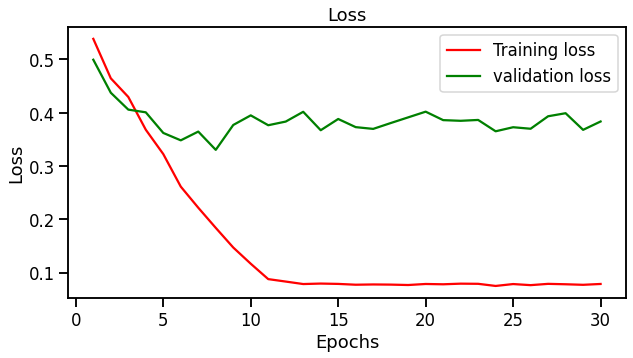

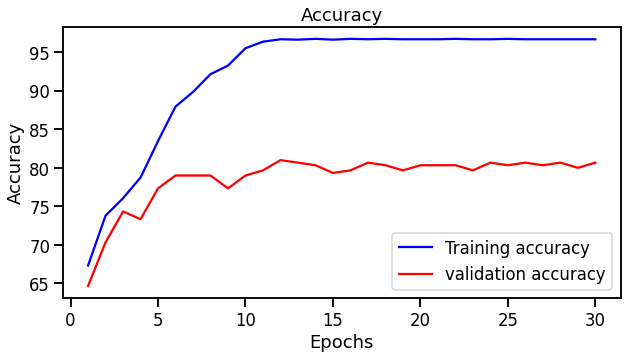

Accuracy of the Model on Train Data : 96.73684210526315
Accuracy of the Model on Validation Data : 80.66666666666666
CLASS  : 0                    	RECALL : 0.85 	PRECISION : 0.78
CLASS  : 1                    	RECALL : 0.43 	PRECISION : 0.58
CLASS  : 2                    	RECALL : 0.89 	PRECISION : 0.90
F1 Score :0.74
Accuracy of the Model on Test Data : 83.15789473684211


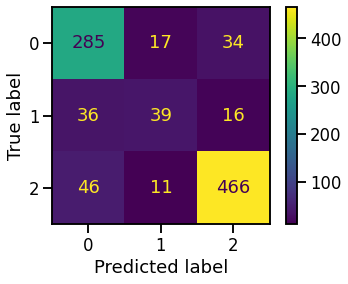

In [ ]:
train_data, val_data, test_data, vocab, weights_matrix = loader_map(src, emb_src, prof_src, 50 , 50)
vocab_size = len(vocab)
output_dim  =  3
emb_dim = 50 
hid_dim = 150 
model = RNNModel(output_dim, emb_dim , hid_dim , weights_matrix,dropout = 0.5).cuda()
optimizer = optim.Adam(model.parameters(), lr= 1e-3)
scheduler =torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,factor=0.1,patience=1,verbose=True)
criterion = nn.BCEWithLogitsLoss().cuda()
trainer(model, train_data, val_data,test_data, optimizer, criterion, 30,scheduler)

In [ ]:
class CNNmodel(nn.Module):
    def __init__(self, embedding_dim, n_filters, filter_sizes, output_dim, weights_matrix, dropout):
        super(CNNmodel, self).__init__()
        self.embedding = nn.Embedding.from_pretrained(weights_matrix, freeze = False)
        self.conv_0 = nn.Conv1d(in_channels = 1, out_channels = n_filters, kernel_size=(filter_sizes[0], embedding_dim))
        self.conv_1 = nn.Conv1d(in_channels = 1, out_channels = n_filters, kernel_size=(filter_sizes[1], embedding_dim))
        self.conv_2 = nn.Conv1d(in_channels = 1, out_channels = n_filters, kernel_size=(filter_sizes[2], embedding_dim))
        self.linear = nn.Linear(len(filter_sizes)*n_filters, output_dim)#
        self.dropout = nn.Dropout(dropout)
    def forward(self, x):
        embedded = self.embedding(x) #o/p->[batch size, sent len, emb dim]
        embedded = embedded.unsqueeze(1)#o/p->[batch size,1, sent len, emb dim]
        conved_0 = F.relu(self.conv_0(embedded.squeeze(3)))
        conved_1 = F.relu(self.conv_1(embedded.squeeze(3)))
        conved_2 = F.relu(self.conv_2(embedded.squeeze(3)))
        pooled_0 = F.max_pool1d(conved_0.squeeze(3), conved_0.shape[2]).squeeze(2)
        pooled_1 = F.max_pool1d(conved_1.squeeze(3), conved_1.shape[2]).squeeze(2)
        pooled_2 = F.max_pool1d(conved_2.squeeze(3), conved_2.shape[2]).squeeze(2)
        out = self.dropout(torch.cat((pooled_0, pooled_1, pooled_2), dim = 1))
        out = self.linear(out)
        return out 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1913 entries, 0 to 1912
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   index   1913 non-null   int64 
 1   text    1908 non-null   object
 2   score   1913 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 45.0+ KB


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:62: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/38 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:89: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch     5: reducing learning rate of group 0 to 5.5000e-03.


  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch     8: reducing learning rate of group 0 to 3.0250e-03.


  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch    11: reducing learning rate of group 0 to 1.6638e-03.


  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch    14: reducing learning rate of group 0 to 9.1506e-04.


  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch    17: reducing learning rate of group 0 to 5.0328e-04.


  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch    20: reducing learning rate of group 0 to 2.7681e-04.


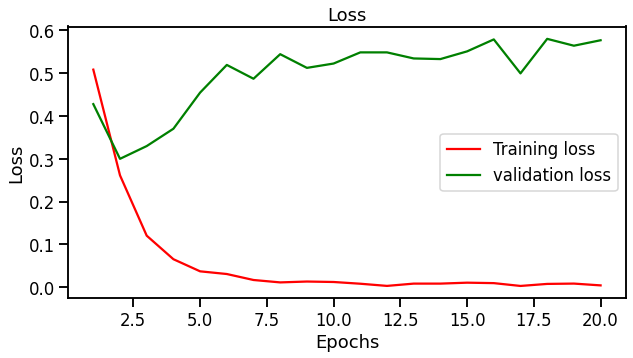

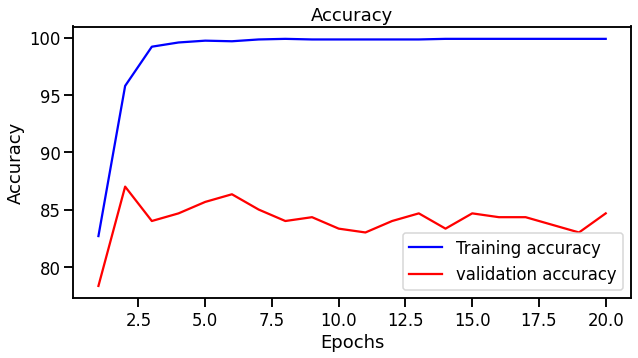

Accuracy of the Model on Train Data : 99.89473684210526
Accuracy of the Model on Validation Data : 83.66666666666667
CLASS  : 0                    	RECALL : 0.84 	PRECISION : 0.83
CLASS  : 1                    	RECALL : 0.45 	PRECISION : 0.69
CLASS  : 2                    	RECALL : 0.93 	PRECISION : 0.89
F1 Score :0.77
Accuracy of the Model on Test Data : 86.10526315789474


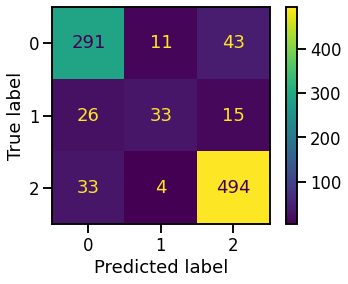

In [ ]:
train_data, val_data, test_data, vocab, weights_matrix = loader_map(src, emb_src, prof_src, 50 , 50)
embedding_dim = 50
n_filters = 150
filter_sizes = [3,4,5]
output_dim = 3
dropout = 0.5

model = CNNmodel(embedding_dim, n_filters , filter_sizes, output_dim, weights_matrix ,dropout).cuda()
optimizer = optim.Adam(model.parameters(), lr= 1e-2)
scheduler =torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,factor=0.55,patience=2,verbose=True)
criterion = nn.BCEWithLogitsLoss().cuda()

trainer(model, train_data, val_data,test_data, optimizer, criterion, 20,scheduler)

In [ ]:


class RNN(nn.Module):
    def __init__(self, vocab_size, emb_dim, hid_dim, weights_matrix, dropout = 0.5):
        super().__init__()
        """
        We take in the pre-trained embeddings but don't freeze the weights, as the hinglish words might not be in the dictionary. 
        """
        self.embedding = nn.Embedding.from_pretrained(weights_matrix, freeze = False)
        self.rnn = nn.GRU(emb_dim, hid_dim, bidirectional = True)
        self.fc = nn.Linear(2*hid_dim, 3)
        self.hid_dim = 2*hid_dim 
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, src):
        src = src.permute(1,0)
        embedded = self.embedding(src)
        output, hidden = self.rnn(embedded)
        hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1))
        return hidden

class CNN(nn.Module):
    def __init__(self, embedding_dim, n_filters, filter_sizes, output_dim, weights_matrix, dropout):
        super().__init__()
        self.embedding = nn.Embedding.from_pretrained(weights_matrix, freeze = False)
        self.conv_0 = nn.Conv1d(in_channels = 1, out_channels = n_filters, kernel_size=(filter_sizes[0], embedding_dim))
        self.conv_1 = nn.Conv1d(in_channels = 1, out_channels = n_filters, kernel_size=(filter_sizes[1], embedding_dim))
        self.conv_2 = nn.Conv1d(in_channels = 1, out_channels = n_filters, kernel_size=(filter_sizes[2], embedding_dim))
        self.linear = nn.Linear(len(filter_sizes)*n_filters, output_dim)#
        self.len_layer = len(filter_sizes)*n_filters
        self.dropout = nn.Dropout(dropout)
    def forward(self, x):
        embedded = self.embedding(x) #o/p->[batch size, sent len, emb dim]
        embedded = embedded.unsqueeze(1)#o/p->[batch size,1, sent len, emb dim]
        conved_0 = F.relu(self.conv_0(embedded.squeeze(3)))
        conved_1 = F.relu(self.conv_1(embedded.squeeze(3)))
        conved_2 = F.relu(self.conv_2(embedded.squeeze(3)))
        pooled_0 = F.max_pool1d(conved_0.squeeze(3), conved_0.shape[2]).squeeze(2)
        pooled_1 = F.max_pool1d(conved_1.squeeze(3), conved_1.shape[2]).squeeze(2)
        pooled_2 = F.max_pool1d(conved_2.squeeze(3), conved_2.shape[2]).squeeze(2)
        out = self.dropout(torch.cat((pooled_0, pooled_1, pooled_2), dim = 1))
        return out 

class RNN_CNNmodel(nn.Module):
    def __init__(self, cnn, rnn, output_dim, dropout):
        super().__init__()
        self.cnn = cnn
        self.rnn = rnn 
        self.fc1 = nn.Linear(cnn.len_layer + rnn.hid_dim, 100)
        self.maxpool = nn.MaxPool1d(2)
        self.fc2 = nn.Linear(50, output_dim)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x):
        """
    	After getting the layer as described above, we pass it through a maxpooling layer and then a linear layer again to get the output. 
    	"""
        out1 = self.cnn(x)
        out2 = self.rnn(x)
        out = torch.cat((out1,out2), dim = 1)
        out = self.fc1(out)
        out = out.unsqueeze(0)
        out = self.maxpool(out)
        out = out.squeeze()
        out = self.fc2(out)
        return out
    


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1913 entries, 0 to 1912
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   index   1913 non-null   int64 
 1   text    1909 non-null   object
 2   score   1913 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 45.0+ KB


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:62: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/38 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:89: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch     5: reducing learning rate of group 0 to 5.5000e-03.


  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch     8: reducing learning rate of group 0 to 3.0250e-03.


  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch    11: reducing learning rate of group 0 to 1.6638e-03.


  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch    14: reducing learning rate of group 0 to 9.1506e-04.


  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch    17: reducing learning rate of group 0 to 5.0328e-04.


  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch    20: reducing learning rate of group 0 to 2.7681e-04.


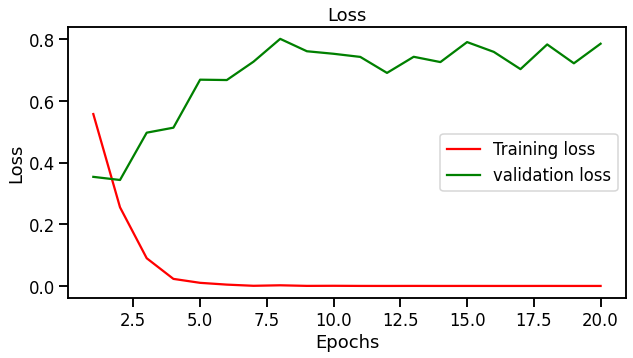

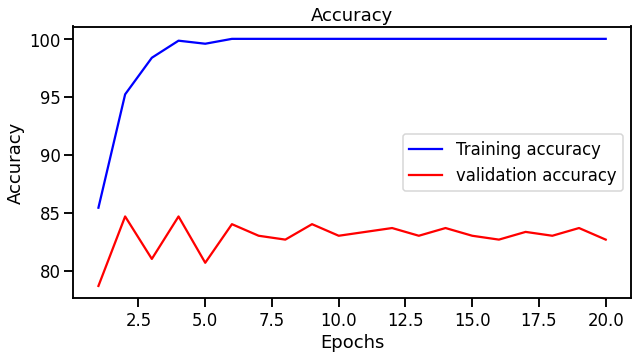

Accuracy of the Model on Train Data : 100.0
Accuracy of the Model on Validation Data : 83.66666666666667
CLASS  : 0                    	RECALL : 0.83 	PRECISION : 0.76
CLASS  : 1                    	RECALL : 0.38 	PRECISION : 0.70
CLASS  : 2                    	RECALL : 0.92 	PRECISION : 0.89
F1 Score :0.74
Accuracy of the Model on Test Data : 82.73684210526315


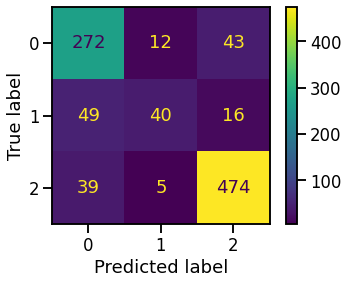

In [ ]:

train_data, val_data, test_data, vocab, weights_matrix = loader_map(src, emb_src, prof_src, 50 , 50)
embedding_dim = 50
n_filters = 150
filter_sizes = [3,4,5]
output_dim = 3
dropout = 0.3

cnn = CNN(embedding_dim, n_filters , filter_sizes, output_dim,weights_matrix, dropout).cuda()
rnn = RNN(vocab_size, 50, 100, weights_matrix, dropout = dropout).cuda()

model = RNN_CNNmodel(cnn, rnn, 3, dropout).cuda()
optimizer = optim.Adam(model.parameters(), lr= 1e-2)
scheduler =torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,factor=0.55,patience=2,verbose=True)
criterion = nn.BCEWithLogitsLoss().cuda()

trainer(model, train_data, val_data,test_data, optimizer, criterion, 20,scheduler)

In [ ]:

class LSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, bidirectional):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers, bidirectional=bidirectional,
                            dropout=dropout_rate, batch_first=True)
        self.fc = nn.Linear(hidden_dim * 2 if bidirectional else hidden_dim, output_dim)
        #self.dropout = nn.Dropout(dropout_rate)
        
    def forward(self, src):
        # ids = [batch size, seq len]
        # length = [batch size]
        embedded = self.embedding(src)
        # embedded = [batch size, seq len, embedding dim]
        
        output, hidden = self.lstm(embedded)
        #hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1)
        
        # output = [batch size, seq len, hidden dim * n directions]
        '''if self.lstm.bidirectional:
            hidden = self.dropout(torch.cat([hidden[-1], hidden[-2]], dim=-1))
            # hidden = [batch size, hidden dim * 2]
        else:
            hidden = self.dropout(hidden[-1])
            # hidden = [batch size, hidden dim]'''
        output = output[:,-1,:]
        prediction = self.fc(output)
        # prediction = [batch size, output dim]
        return prediction
       

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1913 entries, 0 to 1912
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   index   1913 non-null   int64 
 1   text    1911 non-null   object
 2   score   1913 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 45.0+ KB


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:62: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/38 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:89: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch    14: reducing learning rate of group 0 to 1.0000e-03.


  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch    18: reducing learning rate of group 0 to 1.0000e-04.


  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

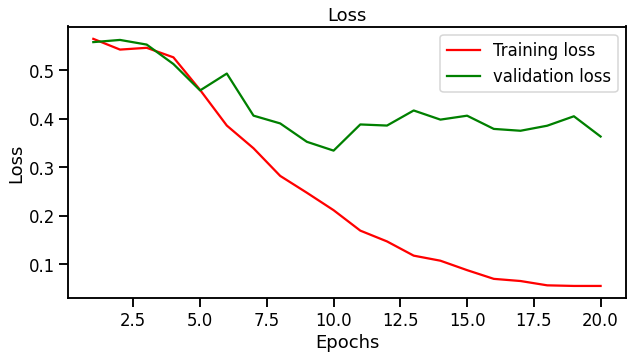

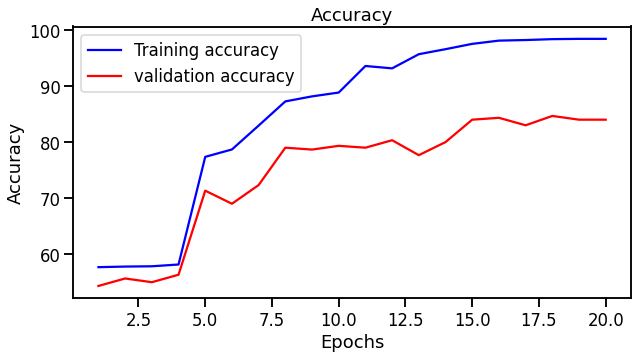

Accuracy of the Model on Train Data : 98.42105263157895
Accuracy of the Model on Validation Data : 84.66666666666667
CLASS  : 0                    	RECALL : 0.72 	PRECISION : 0.82
CLASS  : 1                    	RECALL : 0.45 	PRECISION : 0.34
CLASS  : 2                    	RECALL : 0.88 	PRECISION : 0.86
F1 Score :0.68
Accuracy of the Model on Test Data : 78.42105263157895


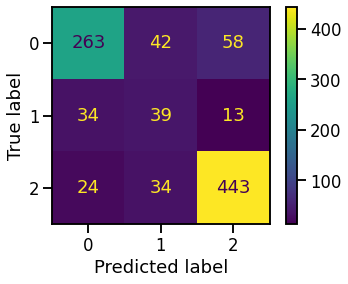

In [ ]:

train_data, val_data, test_data, vocab, weights_matrix = loader_map(src, emb_src, prof_src, 50 , 50)

vocab_size = len(vocab)
embedding_dim = 50
hidden_dim = 150
output_dim = 3
n_layers = 2
bidirectional = True
dropout_rate = 0.5


model = LSTM(vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, bidirectional)
model.cuda()
optimizer = optim.Adam(model.parameters(), lr= 1e-2)
scheduler =torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,factor=0.1,patience=3,verbose=True)
criterion = nn.BCEWithLogitsLoss().cuda()
trainer(model, train_data, val_data,test_data, optimizer, criterion, 20,scheduler)

In [ ]:
class LSTM12(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, bidirectional,dropout_rate):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers, bidirectional=bidirectional,
                            dropout=dropout_rate, batch_first=True)
        self.fc = nn.Linear(hidden_dim * 2 if bidirectional else hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout_rate)
        
    def forward(self, src):
        embedded = self.embedding(src)
        output, hidden = self.lstm(embedded)
        #hidden = self.dropout(torch.cat((output[-2,:,:], output[-1,:,:]), dim=1)

        output = self.dropout(output[:,-1,:])
        prediction = self.fc(output.squeeze())
      
        return prediction

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1913 entries, 0 to 1912
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   index   1913 non-null   int64 
 1   text    1910 non-null   object
 2   score   1913 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 45.0+ KB


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:62: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/38 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:89: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch     6: reducing learning rate of group 0 to 1.0000e-03.


  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch    20: reducing learning rate of group 0 to 1.0000e-04.


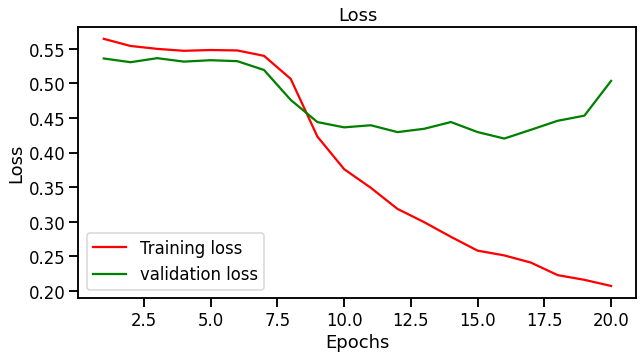

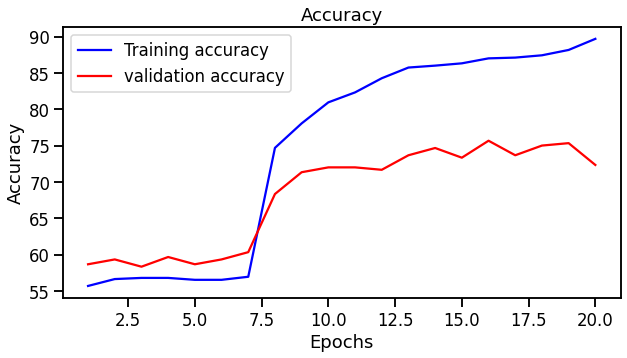

Accuracy of the Model on Train Data : 89.89473684210526
Accuracy of the Model on Validation Data : 71.66666666666667
CLASS  : 0                    	RECALL : 0.74 	PRECISION : 0.72
CLASS  : 1                    	RECALL : 0.15 	PRECISION : 0.19
CLASS  : 2                    	RECALL : 0.85 	PRECISION : 0.83
F1 Score :0.58
Accuracy of the Model on Test Data : 73.78947368421052


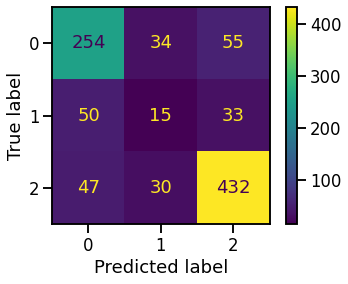

In [ ]:

train_data, val_data, test_data, vocab, weights_matrix = loader_map(src, emb_src, prof_src, 50 , 50)

vocab_size = len(vocab)
embedding_dim = 50
hidden_dim = 50
output_dim = 3
n_layers = 2
#bidirectional = False
dropout_rate = 0.5


model = LSTM12(vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, bidirectional=True,dropout_rate=0.5)
model.cuda()
optimizer = optim.Adam(model.parameters(), lr= 1e-2)
scheduler =torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,factor=0.1,patience=3,verbose=True)
criterion = nn.BCEWithLogitsLoss().cuda()
trainer(model, train_data, val_data,test_data, optimizer, criterion, 20,scheduler)

In [ ]:
class LSTM13(nn.Module):
     def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, bidirectional,dropout_rate):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers, bidirectional=bidirectional,
                            dropout=dropout_rate, batch_first=True)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
        self.hid_dim = 2*hidden_dim 
        self.dropout = nn.Dropout(dropout_rate)
        
     def forward(self, src):
        embedded = self.embedding(src)
        output, hidden = self.lstm(embedded)
        #hidden = self.dropout(torch.cat((output[-2,:,:], output[-1,:,:]), dim=1)

        output = self.dropout(output[:,-1,:])
        
      
        return output

class CNN14(nn.Module):
    def __init__(self, embedding_dim, n_filters, filter_sizes, output_dim, weights_matrix, dropout):
        super().__init__()
        self.embedding = nn.Embedding.from_pretrained(weights_matrix, freeze = False)
        self.conv_0 = nn.Conv1d(in_channels = 1, out_channels = n_filters, kernel_size=(filter_sizes[0], embedding_dim))
        self.conv_1 = nn.Conv1d(in_channels = 1, out_channels = n_filters, kernel_size=(filter_sizes[1], embedding_dim))
        self.conv_2 = nn.Conv1d(in_channels = 1, out_channels = n_filters, kernel_size=(filter_sizes[2], embedding_dim))
        self.linear = nn.Linear(len(filter_sizes)*n_filters, output_dim)#
        self.len_layer = len(filter_sizes)*n_filters
        self.dropout = nn.Dropout(dropout)
    def forward(self, x):
        embedded = self.embedding(x) #o/p->[batch size, sent len, emb dim]
        embedded = embedded.unsqueeze(1)#o/p->[batch size,1, sent len, emb dim]
        conved_0 = F.relu(self.conv_0(embedded.squeeze(3)))
        conved_1 = F.relu(self.conv_1(embedded.squeeze(3)))
        conved_2 = F.relu(self.conv_2(embedded.squeeze(3)))
        pooled_0 = F.max_pool1d(conved_0.squeeze(3), conved_0.shape[2]).squeeze(2)
        pooled_1 = F.max_pool1d(conved_1.squeeze(3), conved_1.shape[2]).squeeze(2)
        pooled_2 = F.max_pool1d(conved_2.squeeze(3), conved_2.shape[2]).squeeze(2)
        out = self.dropout(torch.cat((pooled_0, pooled_1, pooled_2), dim = 1))
        return out 

class LSTM13_CNNmodel(nn.Module):
    def __init__(self, cnn, rnn, output_dim, dropout):
        super().__init__()
        self.cnn = cnn
        self.rnn = rnn 
        self.fc1 = nn.Linear(cnn.len_layer + rnn.hid_dim, 100)
        self.maxpool = nn.MaxPool1d(2)
        self.fc2 = nn.Linear(50, output_dim)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x):
        """
    	After getting the layer as described above, we pass it through a maxpooling layer and then a linear layer again to get the output. 
    	"""
        out1 = self.cnn(x)
        out2 = self.rnn(x)
        out = torch.cat((out1,out2), dim = 1)
        out = self.fc1(out)
        out = out.unsqueeze(0)
        out = self.maxpool(out)
        out = out.squeeze()
        out = self.fc2(out)
        return out

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1913 entries, 0 to 1912
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   index   1913 non-null   int64 
 1   text    1909 non-null   object
 2   score   1913 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 45.0+ KB


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:62: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/38 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:89: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch     6: reducing learning rate of group 0 to 1.0000e-03.


  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch    10: reducing learning rate of group 0 to 1.0000e-04.


  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch    14: reducing learning rate of group 0 to 1.0000e-05.


  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch    18: reducing learning rate of group 0 to 1.0000e-06.


  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

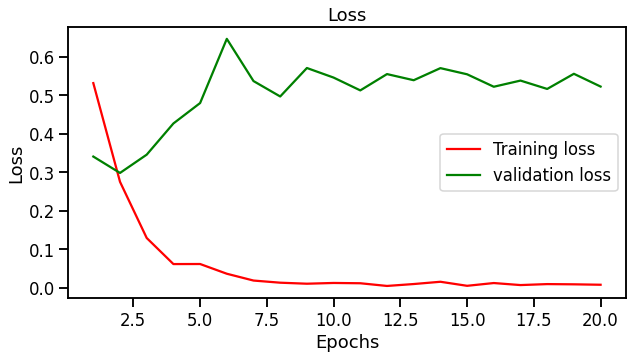

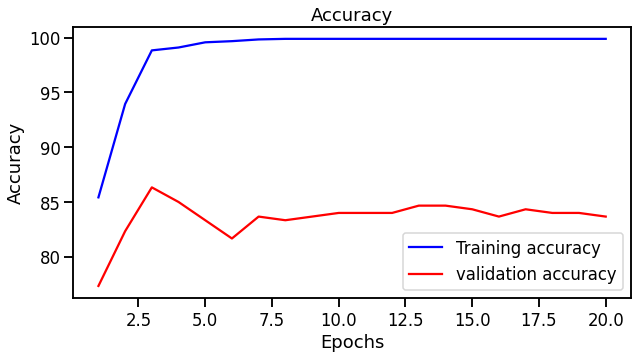

Accuracy of the Model on Train Data : 99.89473684210526
Accuracy of the Model on Validation Data : 84.0
CLASS  : 0                    	RECALL : 0.83 	PRECISION : 0.79
CLASS  : 1                    	RECALL : 0.36 	PRECISION : 0.62
CLASS  : 2                    	RECALL : 0.92 	PRECISION : 0.89
F1 Score :0.73
Accuracy of the Model on Test Data : 83.57894736842105


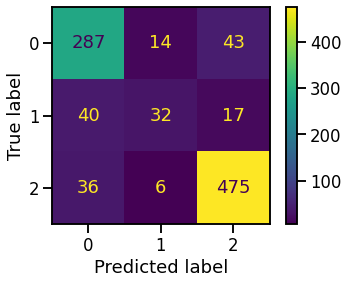

In [ ]:

train_data, val_data, test_data, vocab, weights_matrix = loader_map(src, emb_src, prof_src, 50 , 50)
embedding_dim = 50
n_filters = 128
filter_sizes = [3,4,5]
output_dim = 3
dropout = 0.5
vocab_size = len(vocab)
hidden_dim = 128

n_layers = 2
bidirectional = True
dropout_rate = 0.5

cnn = CNN14(embedding_dim, n_filters , filter_sizes, output_dim,weights_matrix, dropout).cuda()
rnn = LSTM13(vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, bidirectional=True,dropout_rate=0.5).cuda()

model = LSTM13_CNNmodel(cnn, rnn, 3, dropout).cuda()
optimizer = optim.Adam(model.parameters(), lr= 1e-2)
scheduler =torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,factor=0.1,patience=3,verbose=True)
criterion = nn.BCEWithLogitsLoss().cuda()
trainer(model, train_data, val_data,test_data, optimizer, criterion, 20,scheduler)

# New Section

In [12]:

class AttentionModel(torch.nn.Module):
	def __init__(self, batch_size, output_size, hidden_size, vocab_size, embedding_length, weights,dropout):
		super(AttentionModel, self).__init__()
	
		self.dropout=nn.Dropout(dropout)
		self.batch_size = batch_size
		self.output_size = output_size
		self.hidden_size = hidden_size
		self.vocab_size = vocab_size
		self.embedding_length = embedding_length
		self.word_embeddings = nn.Embedding(vocab_size, embedding_length)
		self.word_embeddings.weights = weights
		self.lstm = nn.LSTM(embedding_length, hidden_size)
		self.label = nn.Linear(hidden_size, output_size)
  
		
	def attention_net(self, lstm_output, final_state):
		
		hidden = final_state.squeeze(0)
		attn_weights = torch.bmm(lstm_output, hidden.unsqueeze(2)).squeeze(2)
		soft_attn_weights = F.softmax(attn_weights, 1)
		new_hidden_state = torch.bmm(lstm_output.transpose(1, 2), soft_attn_weights.unsqueeze(2)).squeeze(2)
		
		return new_hidden_state
	
	def forward(self, input_sentences, batch_size=None):
	
		
		input = self.word_embeddings(input_sentences)
		input = input.permute(1, 0, 2)
		if batch_size is None:
			h_0 = Variable(torch.zeros(1, self.batch_size, self.hidden_size).cuda())
			c_0 = Variable(torch.zeros(1, self.batch_size, self.hidden_size).cuda())
		else:
			h_0 = Variable(torch.zeros(1, batch_size, self.hidden_size).cuda())
			c_0 = Variable(torch.zeros(1, batch_size, self.hidden_size).cuda())
			
		output, (final_hidden_state, final_cell_state) = self.lstm(input, (h_0, c_0))# final_hidden_state.size() = (1, batch_size, hidden_size)
		output=self.dropout(output) 
    #output = self.dropout(output[:,-1,:])
		output = output.permute(1, 0, 2) # output.size() = (batch_size, num_seq, hidden_size)
		
		attn_output = self.attention_net(output, final_hidden_state)
		logits = self.label(attn_output)
		
		return logits

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1913 entries, 0 to 1912
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   index   1913 non-null   int64 
 1   text    1909 non-null   object
 2   score   1913 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 45.0+ KB


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:63: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:70: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/38 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:90: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch    19: reducing learning rate of group 0 to 1.0000e-04.


  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

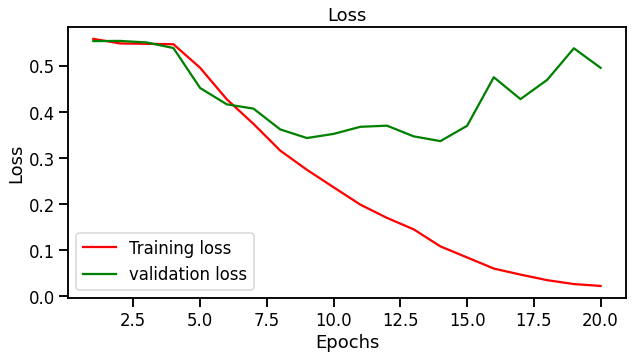

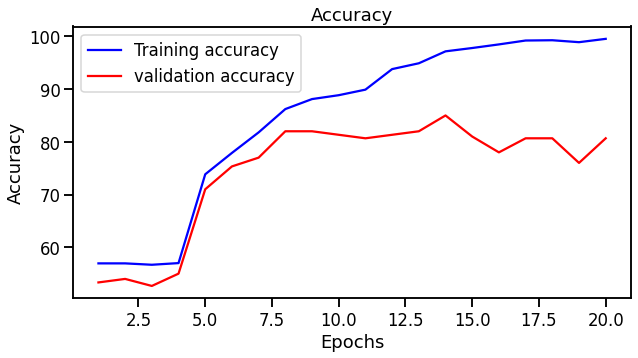

Accuracy of the Model on Train Data : 99.57894736842105
Accuracy of the Model on Validation Data : 80.0
CLASS  : 0                    	RECALL : 0.76 	PRECISION : 0.79
CLASS  : 1                    	RECALL : 0.47 	PRECISION : 0.44
CLASS  : 2                    	RECALL : 0.89 	PRECISION : 0.88
F1 Score :0.71
Accuracy of the Model on Test Data : 80.3157894736842


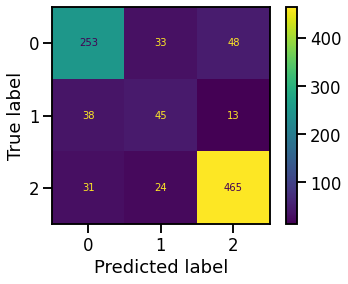

In [13]:
train_data, val_data, test_data, vocab, weights = loader_map(src, emb_src, prof_src, 50 , 50)
device='cuda' if torch.cuda.is_available() else 'cpu'
#print(weights)
emb_dim = 256
hid_dim = 1024
dropout = 0.5
batch_size=50
output_dim=3
#model = model.to(device)
model = AttentionModel(batch_size, output_dim, hid_dim, len(vocab), emb_dim, weights,dropout).cuda()
optimizer = optim.Adam(model.parameters(), lr= 1e-3)
scheduler =torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,factor=0.1,patience=4,verbose=True)
criterion = nn.BCEWithLogitsLoss().cuda()
trainer(model, train_data, val_data,test_data, optimizer, criterion, 20,scheduler)

In [ ]:
class CNN15(nn.Module):
    def __init__(self, embedding_dim, n_filters, filter_sizes, output_dim, weights_matrix, dropout):
        super().__init__()
        self.embedding = nn.Embedding.from_pretrained(weights_matrix, freeze = False)
        self.conv_0 = nn.Conv1d(in_channels = 1, out_channels = n_filters, kernel_size=(filter_sizes[0], embedding_dim))
        self.conv_1 = nn.Conv1d(in_channels = 1, out_channels = n_filters, kernel_size=(filter_sizes[1], embedding_dim))
        self.conv_2 = nn.Conv1d(in_channels = 1, out_channels = n_filters, kernel_size=(filter_sizes[2], embedding_dim))
        self.linear = nn.Linear(len(filter_sizes)*n_filters, output_dim)#
        self.len_layer = len(filter_sizes)*n_filters
        self.dropout = nn.Dropout(dropout)
    def forward(self, x):
        embedded = self.embedding(x) #o/p->[batch size, sent len, emb dim]
        embedded = embedded.unsqueeze(1)#o/p->[batch size,1, sent len, emb dim]
        conved_0 = F.relu(self.conv_0(embedded.squeeze(3)))
        conved_1 = F.relu(self.conv_1(embedded.squeeze(3)))
        conved_2 = F.relu(self.conv_2(embedded.squeeze(3)))
        pooled_0 = F.max_pool1d(conved_0.squeeze(3), conved_0.shape[2]).squeeze(2)
        pooled_1 = F.max_pool1d(conved_1.squeeze(3), conved_1.shape[2]).squeeze(2)
        pooled_2 = F.max_pool1d(conved_2.squeeze(3), conved_2.shape[2]).squeeze(2)
        out = self.dropout(torch.cat((pooled_0, pooled_1, pooled_2), dim = 1))
        return out 

class LSTM14_CNNmodel(nn.Module):
    def __init__(self, cnn, atten, output_dim, dropout):
        super().__init__()
        self.cnn = cnn
        self.atten = atten 
        self.fc1 = nn.Linear(cnn.len_layer, 100)
        self.maxpool = nn.MaxPool1d(2)
        self.fc2 = nn.Linear(50, output_dim)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x):
        
        out1 = self.cnn(x)
        out2 = self.atten(x)
        out = torch.cat((out1,out2), dim = 1)
        out = self.fc1(out)
        out = out.unsqueeze(0)
        out = self.maxpool(out)
        out = out.squeeze()
        out = self.fc2(out)
        return out

class SelfAttention(torch.nn.Module):
	def __init__(self, batch_size, output_size, hidden_size, vocab_size, embedding_length, weights,dropout):
		super(SelfAttention, self).__init__()
	
		self.dropout=nn.Dropout(dropout)
		self.batch_size = batch_size
		self.output_size = output_size
		self.hidden_size = hidden_size
		self.vocab_size = vocab_size
		self.embedding_length = embedding_length
		self.word_embeddings = nn.Embedding(vocab_size, embedding_length)
		self.word_embeddings.weights = weights
		self.lstm = nn.LSTM(embedding_length, hidden_size)
		self.label = nn.Linear(hidden_size, output_size)
  
		
	def attention_net(self, lstm_output, final_state):


		hidden = final_state.squeeze(0)
		attn_weights = torch.bmm(lstm_output, hidden.unsqueeze(2)).squeeze(2)
		soft_attn_weights = F.softmax(attn_weights, 1)
		new_hidden_state = torch.bmm(lstm_output.transpose(1, 2), soft_attn_weights.unsqueeze(2)).squeeze(2)
		
		return new_hidden_state
	
	def forward(self, input_sentences, batch_size=None):
	
		
		input = self.word_embeddings(input_sentences)
		input = input.permute(1, 0, 2)
		if batch_size is None:
			h_0 = Variable(torch.zeros(1, self.batch_size, self.hidden_size).cuda())
			c_0 = Variable(torch.zeros(1, self.batch_size, self.hidden_size).cuda())
		else:
			h_0 = Variable(torch.zeros(1, batch_size, self.hidden_size).cuda())
			c_0 = Variable(torch.zeros(1, batch_size, self.hidden_size).cuda())
			
		output, (final_hidden_state, final_cell_state) = self.lstm(input, (h_0, c_0))# final_hidden_state.size() = (1, batch_size, hidden_size)
		output=self.dropout(output) 
    #output = self.dropout(output[:,-1,:])
		output = output.permute(1, 0, 2) # output.size() = (batch_size, num_seq, hidden_size)
		
		attn_output = self.attention_net(output, final_hidden_state)
		logits = self.label(attn_output)
		
		return logits[:,:-3]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1913 entries, 0 to 1912
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   index   1913 non-null   int64 
 1   text    1910 non-null   object
 2   score   1913 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 45.0+ KB


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:62: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/38 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:89: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch    14: reducing learning rate of group 0 to 1.0000e-04.


  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch    19: reducing learning rate of group 0 to 1.0000e-05.


  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

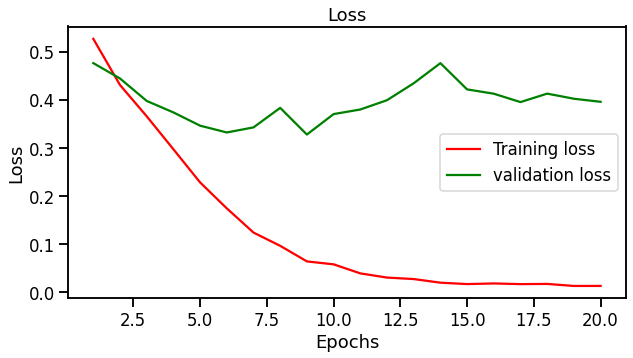

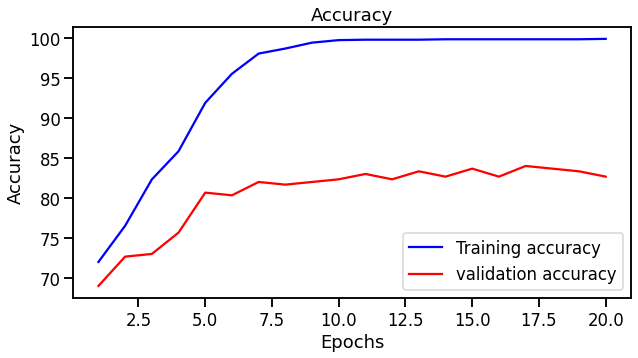

Accuracy of the Model on Train Data : 99.89473684210526
Accuracy of the Model on Validation Data : 83.33333333333334
CLASS  : 0                    	RECALL : 0.85 	PRECISION : 0.77
CLASS  : 1                    	RECALL : 0.44 	PRECISION : 0.67
CLASS  : 2                    	RECALL : 0.88 	PRECISION : 0.89
F1 Score :0.75
Accuracy of the Model on Test Data : 82.84210526315789


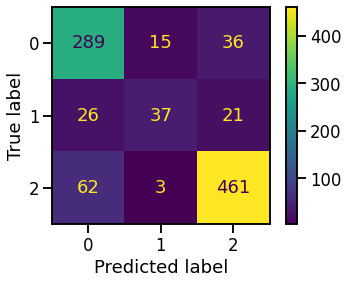

In [ ]:
train_data, val_data, test_data, vocab, weights = loader_map(src, emb_src, prof_src, 50 , 50)
device='cuda' if torch.cuda.is_available() else 'cpu'
#print(weights)
emb_dim = 50
hid_dim = 1024
dropout = 0.5
batch_size=50
output_dim=3
embedding_dim = 50
n_filters = 128
filter_sizes = [3,4,5]
output_dim = 3
dropout = 0.5
vocab_size = len(vocab)
hidden_dim = 128

n_layers = 2
bidirectional = True
dropout_rate = 0.5

#model = model.to(device)

atten = SelfAttention(batch_size, output_dim, hid_dim, len(vocab), emb_dim, weights,dropout).cuda()
cnn = CNN15(emb_dim, 128 , [3,4,5], output_dim,weights, dropout).cuda()

model = LSTM14_CNNmodel(cnn, atten, 3, dropout).cuda()

optimizer = optim.Adam(model.parameters(), lr= 1e-3)
scheduler =torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,factor=0.1,patience=4,verbose=True)
criterion = nn.BCEWithLogitsLoss().cuda()
trainer(model, train_data, val_data,test_data, optimizer, criterion, 20,scheduler)